#Parameter Optimisation
##### Marcus Williamson - 01/09/15

1. Setup Environment
1. Import Algorithm
1. Setup Optimisation Tests
1. Review Performance

##Strategy Parameter Optimisation

###1. Setup Environment
####Import Libraries

In [8]:
import zipline
import pytz
from datetime import datetime
import matplotlib.pyplot as pyplot
from collections import defaultdict

from zipline import TradingAlgorithm
from zipline.api import order_target, record, symbol, history, add_history, order_target_percent
from zipline.api import schedule_function, date_rules, time_rules, order, get_open_orders, get_datetime
from zipline.api import set_slippage, set_commission
from zipline.api import slippage
from zipline.api import commission

from zipline.utils import tradingcalendar

import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

import time

####Define functions for evaluating performance

In [16]:
# define a bunch of performance statistics for analysis of our backtests
def normalize(returns, starting_value=1):
    return starting_value * (returns / returns.iloc[0])


def cum_returns(returns, starting_value=None):

    # df_price.pct_change() adds a nan in first position, we can use
    # that to have cum_returns start at the origin so that
    # df_cum.iloc[0] == starting_value
    # Note that we can't add that ourselves as we don't know which dt
    # to use.
    if pd.isnull(returns.iloc[0]):
        returns.iloc[0] = 0.

    df_cum = np.exp(np.log(1 + returns).cumsum())

    if starting_value is None:
        return df_cum - 1
    else:
        return df_cum * starting_value


def aggregate_returns(df_daily_rets, convert_to):

    def cumulate_returns(x):
        return cum_returns(x)[-1]

    if convert_to == 'weekly':
        return df_daily_rets.groupby(
            [lambda x: x.year,
             lambda x: x.month,
             lambda x: x.isocalendar()[1]]).apply(cumulate_returns)
    elif convert_to == 'monthly':
        return df_daily_rets.groupby(
            [lambda x: x.year, lambda x: x.month]).apply(cumulate_returns)
    elif convert_to == 'yearly':
        return df_daily_rets.groupby(
            [lambda x: x.year]).apply(cumulate_returns)
    else:
        ValueError('convert_to must be weekly, monthly or yearly')


def max_drawdown(returns):

    if returns.size < 1:
        return np.nan

    df_cum_rets = cum_returns(returns, starting_value=100)

    MDD = 0
    DD = 0
    peak = -99999
    for value in df_cum_rets:
        if (value > peak):
            peak = value
        else:
            DD = (peak - value) / peak
        if (DD > MDD):
            MDD = DD
    return -1 * MDD


def annual_return(returns, style='compound'):

    if returns.size < 1:
        return np.nan

    if style == 'calendar':
        num_years = len(returns) / 252.0
        df_cum_rets = cum_returns(returns, starting_value=100)
        start_value = df_cum_rets[0]
        end_value = df_cum_rets[-1]
        return ((end_value - start_value) / start_value) / num_years
    if style == 'compound':
        return pow((1 + returns.mean()), 252) - 1
    else:
        return returns.mean() * 252


def annual_volatility(returns):

    if returns.size < 2:
        return np.nan

    return returns.std() * np.sqrt(252)


def calmar_ratio(returns, returns_style='calendar'):

    temp_max_dd = max_drawdown(returns=returns)
    if temp_max_dd < 0:
        temp = annual_return(
            returns=returns,
            style=returns_style) / abs(max_drawdown(returns=returns))
    else:
        return np.nan

    if np.isinf(temp):
        return np.nan

    return temp


def omega_ratio(returns, annual_return_threshhold=0.0):

    daily_return_thresh = pow(1 + annual_return_threshhold, 1 / 252) - 1

    returns_less_thresh = returns - daily_return_thresh

    numer = sum(returns_less_thresh[returns_less_thresh > 0.0])
    denom = -1.0 * sum(returns_less_thresh[returns_less_thresh < 0.0])

    if denom > 0.0:
        return numer / denom
    else:
        return np.nan


def sortino_ratio(returns, returns_style='compound'):

    numer = annual_return(returns, style=returns_style)
    denom = annual_volatility(returns[returns < 0.0])

    if denom > 0.0:
        return numer / denom
    else:
        return np.nan


def sharpe_ratio(returns, returns_style='compound'):

    numer = annual_return(returns, style=returns_style)
    denom = annual_volatility(returns)

    if denom > 0.0:
        return numer / denom
    else:
        return np.nan


def stability_of_timeseries(returns, logValue=True):

    if returns.size < 2:
        return np.nan

    df_cum_rets = cum_returns(returns, starting_value=100)
    temp_values = np.log10(
        df_cum_rets.values) if logValue else df_cum_rets.values
    len_returns = df_cum_rets.size

    X = list(range(0, len_returns))
    X = sm.add_constant(X)

    model = sm.OLS(temp_values, X).fit()

    return model.rsquared

def perf_stats(returns, returns_style='compound', return_as_dict=False):

    all_stats = {}
    all_stats['annual_return'] = annual_return(
        returns,
        style=returns_style)
    all_stats['annual_volatility'] = annual_volatility(returns)
    all_stats['sharpe_ratio'] = sharpe_ratio(
        returns,
        returns_style=returns_style)
    all_stats['calmar_ratio'] = calmar_ratio(
        returns,
        returns_style=returns_style)
    all_stats['stability'] = stability_of_timeseries(returns)
    all_stats['max_drawdown'] = max_drawdown(returns)
    all_stats['omega_ratio'] = omega_ratio(returns)
    all_stats['sortino_ratio'] = sortino_ratio(returns)

    if return_as_dict:
        return all_stats
    else:
        all_stats_df = pd.DataFrame(
            index=list(all_stats.keys()),
            data=list(all_stats.values()))
        all_stats_df.columns = ['perf_stats']
        return all_stats_df
    

###2. Import Algorithm
####Load data for backtests

In [15]:
data = get_pricing(['xx', 'xxx', 'etc..'],start_date='2014-10-01',end_date = '2015-01-01',frequency='minute')

####Define Algorithm

Place Initialize here with parameters outside of function

In [6]:
#Parameters
hedge_lookback = 20
z_window = 20

def initialize(context):
    #PLACE LOGIC HERE
    pass

Place Handle Data here 

In [18]:
def handle_data(context, data):
    #PLACE LOGIC HERE
    pass

Any other functions go here that are called 

In [19]:
def function_insert(context,data):
    #PLACE LOGIC OR DELETE
    pass

####Run test to ensure algorithm is functioning

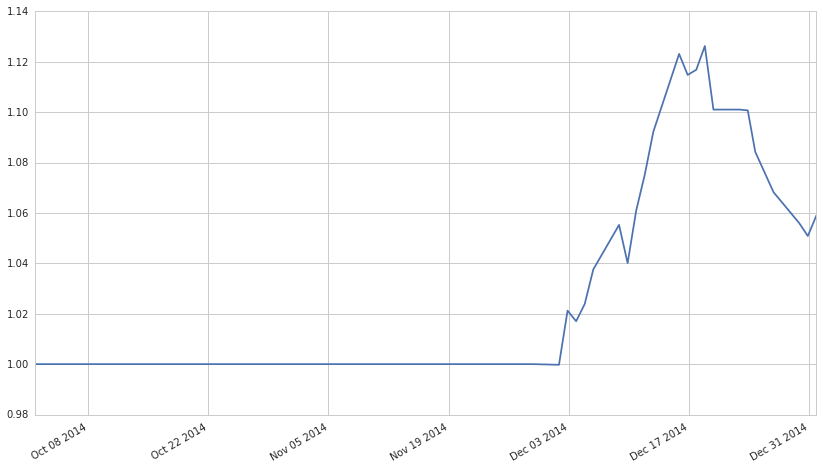

In [20]:
# RUN this cell to run a single backtest
algo_obj = TradingAlgorithm(initialize=initialize, handle_data=handle_data, 
                            data_frequency='minute')

perf_manual = algo_obj.run(data.transpose(2,1,0))
perf_returns = perf_manual.returns     # grab the daily returns from the algo backtest
(np.cumprod(1+perf_returns)).plot()    # plots the performance of your algo

###3. Setup Optimisation Tests
####Setup Parameters

Ensure you decide if you are using int or float

In [9]:
param_range_1 = map(int, np.linspace(20, 30, 5))  
param_range_2 = map(float, np.around(np.linspace(1, 2, 5),decimals=4)) 
print(param_range_1,param_range_2)

([20, 22, 25, 27, 30], [1.0, 1.25, 1.5, 1.75, 2.0])


####Creating Tests - This will take hours!

In [21]:
# Show time when all the backtests started
print time.ctime()

count = 0
results_df = pd.DataFrame()

for param_1 in param_range_1:
    for param_2 in param_range_2:
        print "Run #" + str(count) + ", Parameters: " + str(param_1) + ", " + str(param_2)
        
        ####################################################################################
        ###################################  REDEFINE   ####################################
        ####################################################################################
        
        def initialize(context):
            
            #PLACE INITIALISE LOGIC HERE, ENSURE PARAM'S LINK WITH THOSE IN FOR LOOP
            
            pass
            
        ####################################################################################
        #################################  END REDEFINE   ##################################
        ####################################################################################
        
        # this runs a backtest unique to the values in 'param_1' and 'param_2'
        algo_obj = TradingAlgorithm(initialize=initialize, handle_data=handle_data, 
                            data_frequency='minute')
        
        # compute the performance stats for this backtest run and then append to a dataframe
        # that is accumulating all of the backtest performance stats
        perf_algo = algo_obj.run(data.transpose(2,1,0))
        perf_returns = perf_algo.returns
        perf_stats_df = perf_stats( perf_returns ).T

        perf_stats_df['param_1'] = param_1
        perf_stats_df['param_2'] = param_2
        perf_stats_df.index = [count]
        
        if count < 1:
            results_df = perf_stats_df
        else:
            results_df = results_df.append(perf_stats_df)
        
        count += 1

# Show time when all the backtests completed
print time.ctime()

results_df.sort_index(axis=1)

Tue Sep  1 12:28:41 2015
Run #0, Parameters: 20, 10
Run #1, Parameters: 20, 12
Run #2, Parameters: 20, 15
Run #3, Parameters: 20, 17
Run #4, Parameters: 20, 20
Run #5, Parameters: 22, 10
Run #6, Parameters: 22, 12
Run #7, Parameters: 22, 15
Run #8, Parameters: 22, 17
Run #9, Parameters: 22, 20
Run #10, Parameters: 25, 10
Run #11, Parameters: 25, 12
Run #12, Parameters: 25, 15
Run #13, Parameters: 25, 17
Run #14, Parameters: 25, 20
Run #15, Parameters: 27, 10
Run #16, Parameters: 27, 12
Run #17, Parameters: 27, 15
Run #18, Parameters: 27, 17
Run #19, Parameters: 27, 20
Run #20, Parameters: 30, 10
Run #21, Parameters: 30, 12
Run #22, Parameters: 30, 15
Run #23, Parameters: 30, 17
Run #24, Parameters: 30, 20
Tue Sep  1 12:38:02 2015


,annual_return,annual_volatility,calmar_ratio,max_drawdown,omega_ratio,param_1,param_2,sharpe_ratio,sortino_ratio,stability
0,0.786642,0.150885,25.351040,-0.031030,2.738540,20,10,5.213516,5.858134,0.720516
1,0.696716,0.150541,17.955392,-0.038803,2.731131,20,12,4.628076,4.492630,0.714757
2,0.696716,0.150541,17.955392,-0.038803,2.731131,20,15,4.628076,4.492630,0.714757
3,1.169618,0.208562,37.159847,-0.031475,3.398325,20,17,5.608021,8.136603,0.702161
4,0.263116,0.127498,3.929767,-0.066955,1.625367,20,20,2.063689,2.278431,0.567955
5,0.726136,0.141123,23.038019,-0.031519,2.957294,22,10,5.145430,5.204975,0.733433
6,0.629992,0.140696,19.980161,-0.031531,2.785888,22,12,4.477674,4.395564,0.698141
7,0.770151,0.162240,24.340165,-0.031641,2.873045,22,15,4.746990,5.839256,0.700340
8,0.459320,0.165492,5.391613,-0.085192,1.917347,22,17,2.775478,2.587218,0.583978
9,0.244171,0.134683,4.756296,-0.051336,1.546580,22,20,1.812928,1.970775,0.522288


###4. Review Performance
####Tabulated Results

In [22]:
# you should modify these 2 string labels to match the variables which you ran the above _for_ loops over
# it's just to label the axes properly in the heatmaps

param_name_1 = 'parameter_1'
param_name_2 = 'parameter_2'

results_df[param_name_1] = results_df.param_1
results_df[param_name_2] = results_df.param_2

results_df_sharpe = results_df.pivot(index=param_name_1, columns=param_name_2, values='sharpe_ratio') 
results_df_max_drawdown = results_df.pivot(index=param_name_1, columns=param_name_2, values='max_drawdown') 
results_df_annual_return = results_df.pivot(index=param_name_1, columns=param_name_2, values='annual_return') 
results_df_volatility = results_df.pivot(index=param_name_1, columns=param_name_2, values='annual_volatility') 
results_df_stability = results_df.pivot(index=param_name_1, columns=param_name_2, values='stability') 
results_df_sortino = results_df.pivot(index=param_name_1, columns=param_name_2, values='sortino_ratio') 
results_df_omega = results_df.pivot(index=param_name_1, columns=param_name_2, values='omega_ratio') 
results_df_calmar = results_df.pivot(index=param_name_1, columns=param_name_2, values='calmar_ratio') 

results_df

,sortino_ratio,omega_ratio,max_drawdown,calmar_ratio,annual_return,stability,sharpe_ratio,annual_volatility,param_1,param_2,hedge_lookback,z_window
0,5.858134,2.738540,-0.031030,25.351040,0.786642,0.720516,5.213516,0.150885,20,10,20,10
1,4.492630,2.731131,-0.038803,17.955392,0.696716,0.714757,4.628076,0.150541,20,12,20,12
2,4.492630,2.731131,-0.038803,17.955392,0.696716,0.714757,4.628076,0.150541,20,15,20,15
3,8.136603,3.398325,-0.031475,37.159847,1.169618,0.702161,5.608021,0.208562,20,17,20,17
4,2.278431,1.625367,-0.066955,3.929767,0.263116,0.567955,2.063689,0.127498,20,20,20,20
5,5.204975,2.957294,-0.031519,23.038019,0.726136,0.733433,5.145430,0.141123,22,10,22,10
6,4.395564,2.785888,-0.031531,19.980161,0.629992,0.698141,4.477674,0.140696,22,12,22,12
7,5.839256,2.873045,-0.031641,24.340165,0.770151,0.700340,4.746990,0.162240,22,15,22,15
8,2.587218,1.917347,-0.085192,5.391613,0.459320,0.583978,2.775478,0.165492,22,17,22,17
9,1.970775,1.546580,-0.051336,4.756296,0.244171,0.522288,1.812928,0.134683,22,20,22,20


####Heatmaps - Small

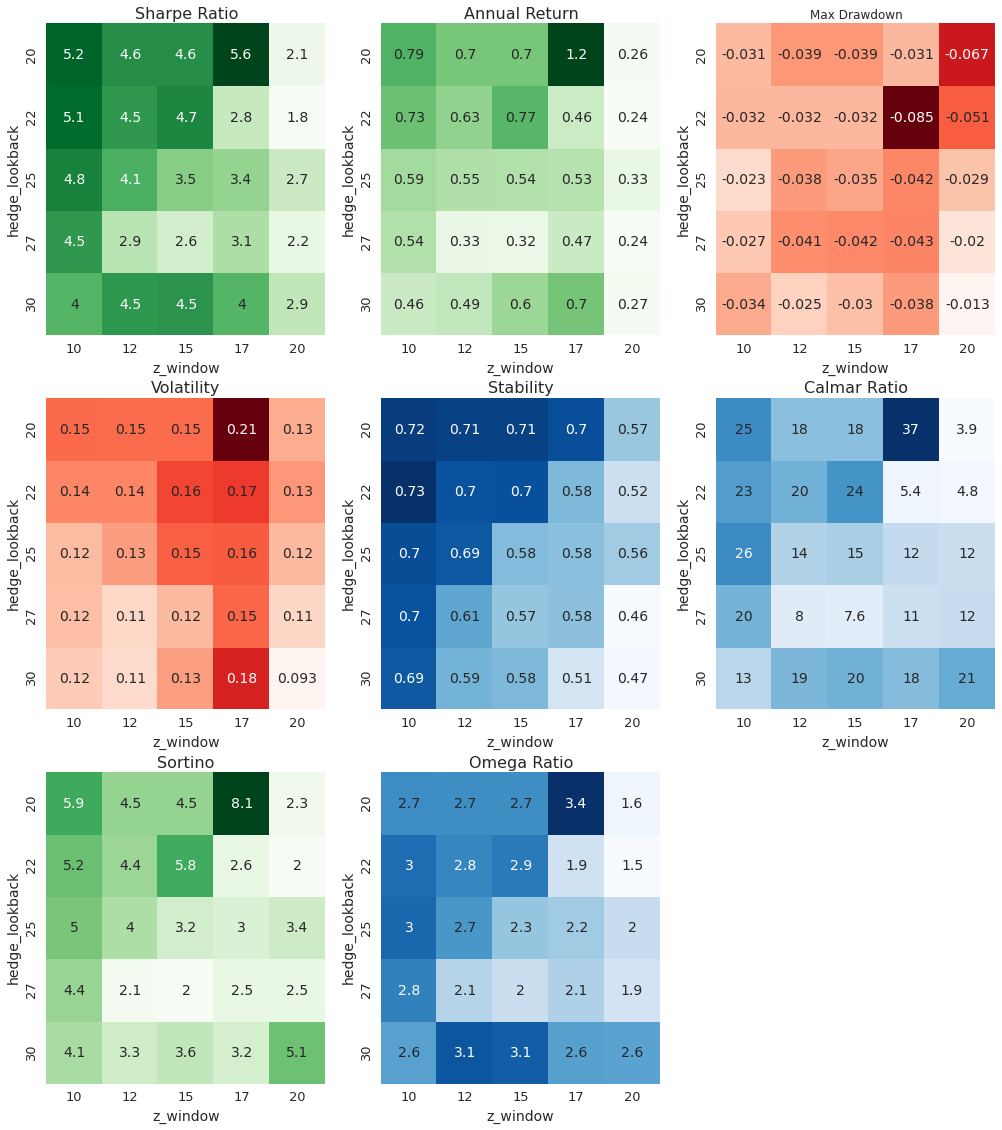

In [23]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(3,3,1)
ax1.set_title("Sharpe Ratio", fontsize=16)
ax1 = sns.heatmap(results_df_sharpe, annot=True, cbar=False, annot_kws={"size": 8}, cmap='Greens')

ax2 = fig.add_subplot(3,3,2)
ax2.set_title("Annual Return", fontsize=16)
ax2 = sns.heatmap(results_df_annual_return, annot=True, cbar=False, annot_kws={"size": 8}, cmap='Greens')

ax3 = fig.add_subplot(3,3,3)
ax3.set_title("Max Drawdown", fontsize=16)
ax3 = sns.heatmap(results_df_max_drawdown, annot=True, cbar=False, annot_kws={"size": 8}, cmap='Reds_r')

ax4 = fig.add_subplot(3,3,4)
ax4.set_title("Volatility", fontsize=16)
ax4 = sns.heatmap(results_df_volatility, annot=True, cbar=False, annot_kws={"size": 8}, cmap='Reds')

ax5 = fig.add_subplot(3,3,5)
ax5.set_title("Stability", fontsize=16)
ax5 = sns.heatmap(results_df_stability, annot=True, cbar=False, annot_kws={"size": 8}, cmap='Blues')

ax6 = fig.add_subplot(3,3,6)
ax6.set_title("Calmar Ratio", fontsize=16)
ax6 = sns.heatmap(results_df_calmar, annot=True, cbar=False, annot_kws={"size": 8}, cmap='Blues')

ax7 = fig.add_subplot(3,3,7)
ax7.set_title("Sortino", fontsize=16)
ax7 = sns.heatmap(results_df_sortino, annot=True, cbar=False, annot_kws={"size": 8}, cmap='Greens')

ax8 = fig.add_subplot(3,3,8)
ax8.set_title("Omega Ratio", fontsize=16)
ax8 = sns.heatmap(results_df_omega, annot=True, cbar=False, annot_kws={"size": 8}, cmap='Blues')

for ax in fig.get_axes():
    ax.tick_params(axis='x', labelsize=3)
    ax.tick_params(axis='y', labelsize=3)
    ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize' : 6})
    ax.set_ylabel(ax.get_ylabel(), fontdict={'fontsize' : 6})

####Heatmaps - Large

In [ ]:
fig = plt.figure(figsize=(15,80))

ax1 = fig.add_subplot(8,1,1)
ax1.set_title("Sharpe Ratio", fontsize=16)
ax1 = sns.heatmap(results_df_sharpe, annot=True, cbar=False, annot_kws={"size": 14}, cmap='Greens')

ax2 = fig.add_subplot(8,1,2)
ax2.set_title("Annual Return", fontsize=16)
ax2 = sns.heatmap(results_df_annual_return, annot=True, cbar=False, annot_kws={"size": 14}, cmap='Greens')

ax3 = fig.add_subplot(8,1,3)
ax3.set_title("Max Drawdown", fontsize=16)
ax3 = sns.heatmap(results_df_max_drawdown, annot=True, cbar=False, annot_kws={"size": 14}, cmap='Reds_r')

ax4 = fig.add_subplot(8,1,4)
ax4.set_title("Volatility", fontsize=16)
ax4 = sns.heatmap(results_df_volatility, annot=True, cbar=False, annot_kws={"size": 14}, cmap='Reds')

ax5 = fig.add_subplot(8,1,5)
ax5.set_title("Stability", fontsize=16)
ax5 = sns.heatmap(results_df_stability, annot=True, cbar=False, annot_kws={"size": 14}, cmap='Blues')

ax6 = fig.add_subplot(8,1,6)
ax6.set_title("Calmar Ratio", fontsize=16)
ax6 = sns.heatmap(results_df_calmar, annot=True, cbar=False, annot_kws={"size": 14}, cmap='Blues')

ax7 = fig.add_subplot(8,1,7)
ax7.set_title("Sortino", fontsize=16)
ax7 = sns.heatmap(results_df_sortino, annot=True, cbar=False, annot_kws={"size": 14}, cmap='Greens')

ax8 = fig.add_subplot(8,1,8)
ax8.set_title("Omega Ratio", fontsize=16)
ax8 = sns.heatmap(results_df_omega, annot=True, cbar=False, annot_kws={"size": 14}, cmap='Blues')

for ax in fig.get_axes():
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize' : 15})
    ax.set_ylabel(ax.get_ylabel(), fontdict={'fontsize' : 15})